# Import libraries and fix randomness

In [ ]:
# Fix randomness and hide warnings
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd() +'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

In [ ]:
# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

2.15.0


In [ ]:
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
plt.rc('font', size=16)
from sklearn.preprocessing import MinMaxScaler

In [ ]:
import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

# Load the data

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

%cd "/gdrive/MyDrive/AN2DL - Challenges/2nd Challenge/Homework Fabio"

Mounted at /gdrive
/gdrive/.shortcut-targets-by-id/11eKW2WEwoP-WDr7xm8XSO8STbxqotVyP/AN2DL - Challenges/2nd Challenge/Homework Fabio


In [ ]:
categories = np.load('../data/categories.npy')
training_data = np.load('../data/training_data.npy')
valid_periods = np.load('../data/valid_periods.npy')

print(f"Training data shape: {training_data.shape}")
print(f"Valid periods shape: {valid_periods.shape}")
print(f"categories shape: {categories.shape}")

Training data shape: (48000, 2776)
Valid periods shape: (48000, 2)
categories shape: (48000,)


In [ ]:
training_data_df = pd.DataFrame(training_data)
valid_periods_df = pd.DataFrame(valid_periods)
categories_df = pd.DataFrame(categories)

# Data inpesction

<Figure size 2800x300 with 0 Axes>

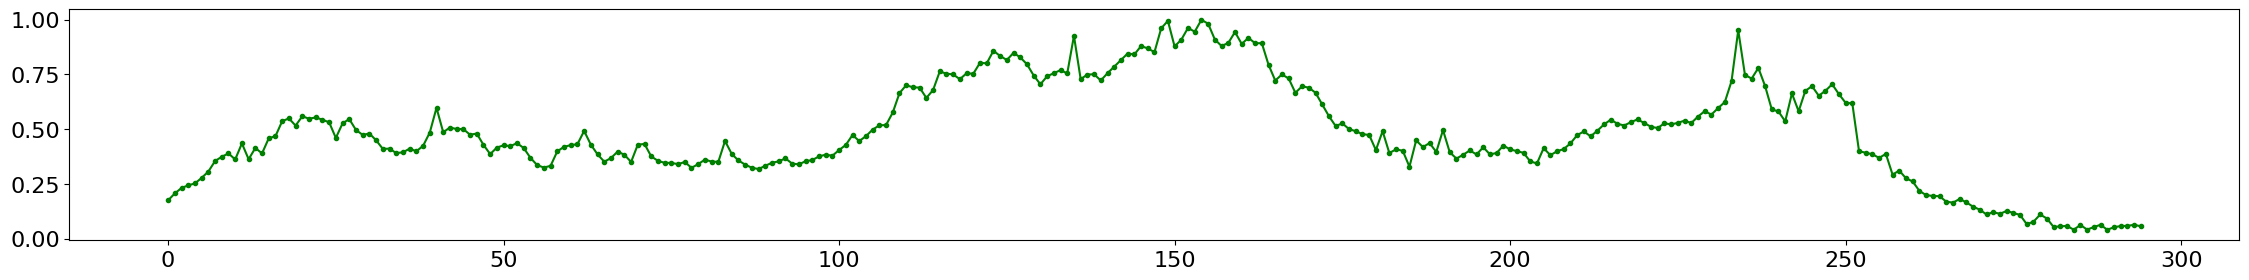

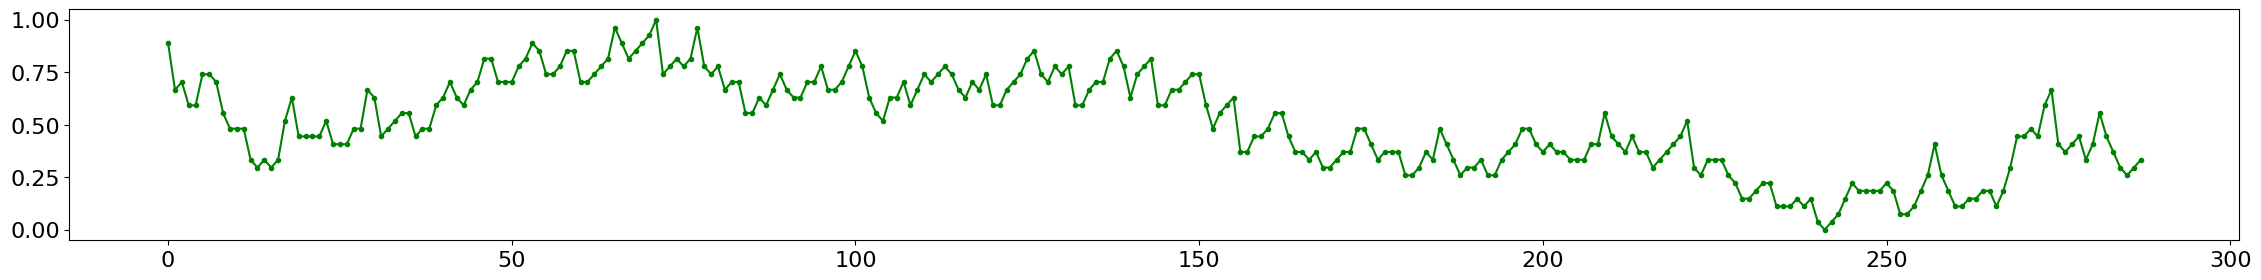

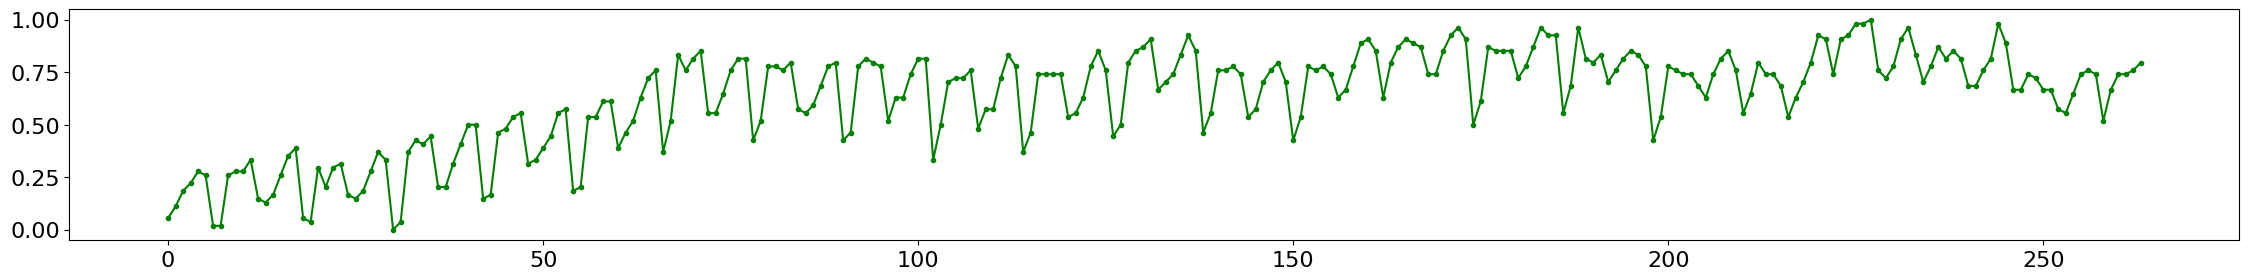

In [ ]:
from matplotlib.lines import Line2D

def inspect_monovariate(X, y, telescope, idx=None):
    if(idx==None):
        idx=np.random.randint(0,len(X))

    # trick to have the target continue the training
    # i.e. we take the last element of the training and concatenate it
    # at the beginning of y
    y = np.concatenate([np.expand_dims(X[:,-1], axis=1),y], axis=1)


    # X[0,:]: 0 is the first sample of training dataset
    #           : take the whole sequnce (i.e. 100)
    # plot training
    plt.figure(figsize=(28,3))
    plt.plot(
        np.arange(len(X[0,:])),
        X[idx,:],
        label='Training sequence')
    # plot target
    plt.plot(
        np.arange(len(X[0])-1, len(X[0])+telescope),
        y[idx],
        color='orange',
        label='Target')
    plt.show()


def inspect_ts(*s, distinct=True, telescope=False):

    plt.figure(figsize=(28,3))
    if telescope:
        if not distinct:
            plt.figure(figsize=(28,3))

        for i in range(0, len(s), 2):
            x = s[i]
            y = s[i+1]

            y = np.concatenate([np.expand_dims(x[-1], axis=0),y])
            # plot training

            if distinct:
                plt.figure(figsize=(28,3))
            plt.plot(
                np.arange(len(x)),
                x,
                marker=Line2D.filled_markers[0],
                label='Training sequence')
            # plot target
            plt.plot(
                np.arange(len(x)-1, len(x)+y.shape[0] - 1),
                y,
                marker=Line2D.filled_markers[0],
                label='Target')
            if distinct:
                plt.show()

        if not distinct:
            plt.show()
    else:
        if not distinct:
            plt.figure(figsize=(28,3))

        for x in s:
            if distinct:
                plt.figure(figsize=(28,3))
            plt.plot(
                np.arange(len(x)),
                x,
                marker=Line2D.filled_markers[0],
                label='Training sequence',
                color='green')
            if distinct:
                plt.show()

        if not distinct:
            plt.show()



tss = []
for i in range(3):
    idx = np.random.randint(training_data.shape[0])
    start = valid_periods[idx,0]
    end = valid_periods[idx,1]
    tss.append(training_data[idx, start:end])

inspect_ts(*tss, distinct=True, telescope=False)

# Prepare Data

In [ ]:
from sklearn import model_selection

# Spkit the data in training, validation and test

test_size = 0.10
X_train_raw, X_test_raw, categories_train, categories_test, valid_periods_train, valid_periods_test = model_selection.train_test_split(
    training_data,
    categories,
    valid_periods,
    test_size=test_size, shuffle=True, stratify=categories)


X_train_raw, X_validation_raw, categories_train, categories_validation, valid_periods_train, valid_periods_validation = model_selection.train_test_split(
    X_train_raw,
    categories_train,
    valid_periods_train,
    test_size=test_size, shuffle=True, stratify=categories_train
)

In [ ]:
def build_sequences_dataset(ts_dataset, valid_periods, categories, category_pool, window=200, stride=50, telescope=50, skip_threshold=150):
    """
    Function that constructs a dataset of fixed-length (sequences) extracted
    from an external dataset of time series of variable length.

    Args:
        ts_dataset: NxM ndarray
            The dataset from wich the sequences will be built.
            Each row must represent the sequence of values of a time series

        valid_periods: Nx2 ndarray
            For each row it tells the valid period of the corresponding
            time series from the `from` matrix in the same row position.

        categories: Nx1 ndarray
            matrix denoting the category of each time series in the corresponding
            row of the ts_dataset matrix

        category_pool: list of str
            The categories from wich we want to extact the sequences.
            Useful if we want to build a sequence dataset from
            time series belong to specific categories.

        window: int
            size of the sequence.

        stride: int
            Values to skip from sequence to sequence.

        telescope: int
            Target sequence. The datapoints from idx+winodw:idx+window+telescope
            will be used as the target for the loss function of the predictor.

        skip_threshold: int
            Minimum number of valid values a sequence shoud have to be padded.

    Return: tuple(X, y)
        X: ndarray of shape(P, window)
        y: ndarray of shape(P, telescope)
    """
    assert window % stride == 0

    sequences = []
    targets = []

    for i in range(0, len(ts_dataset)):
        # get the ts from the right categories
        if categories[i] in category_pool:
            start = valid_periods[i,0]
            end = valid_periods[i,1]

            # skip short sequences
            if end - start < skip_threshold:
                # string with valid period > 150
                # covers 50% of the data
                continue

            series = ts_dataset[i,start:end]
            padding_len = (window + telescope) - series.shape[0] % (window + telescope)

            # deal with padding
            # if the padding is too much skip it
            # In other words we skip the sub-sequences that
            # would result in too much padding by not doing the padding at
            # all so it will be ignored in the ts_split function
            #
            # window + telescope - pading_len is the number of unpadded values
            # of the the candidate sequence
            if (window + telescope - padding_len) > skip_threshold:
                z_padding = np.zeros(padding_len)
                series = np.concatenate((z_padding, series), axis=-1) # concatenate by columns (extend columns)


            seq, targ = ts_split(series, window, stride, telescope)
            # Building the training and target matrix
            sequences += seq
            targets += targ


    return np.array(sequences).astype(np.float32), np.array(targets).astype(np.float32)


def ts_split(time_series, window, stride, telescope):
    """
    Function to sample subsequences from a sequence

    Args:
        time_series: 1xM array
            The time series from which to sample

        window:
            size of the subsequence to be used as input for the prediction

        stride:
            values to skip from a sample to the another

        telescope:
            size of the subsequence to predict

    Returns: tuple(sequences, targets)
        sequences:
            list of lists of size window

        targets:
            list of lists of size telescope
    """

    sequences = []
    targets = []
    # Create the range of indexes nowing that:
    # n_seq = (len(time_series) - (window+telescope)) // stride + 1
    # + 1 for the case when len(time_series) = window+telescope, so we
    # can extracta at least one sequence
    for i in range(0, len(time_series) - (window + telescope) + 1, stride):
        sequences.append(time_series[i:i+window])
        targets.append(time_series[i+window:i+window+telescope])

    return sequences, targets

In [ ]:
window = 200
stride = 20
thresh = 150
telescope = 18 # prediction steps

# telescope for autoregressive model
# direct_telescope < telescope when using
# an autoregressive model
direct_telescope = 3

# categories from which to extract time series
category_pool = ['A', 'B', 'C', 'D', 'E', 'F']


X_train, y_train = build_sequences_dataset(X_train_raw, valid_periods_train, categories_train, category_pool, window, stride, direct_telescope, thresh)
X_val, y_val = build_sequences_dataset(X_validation_raw, valid_periods_validation, categories_validation, category_pool, window, stride, direct_telescope, thresh)

X_test, y_test = build_sequences_dataset(X_test_raw, valid_periods_test, categories_test, category_pool, window, stride, telescope, thresh)


X_train.shape, y_train.shape, X_test.shape, y_test.shape

((116371, 200), (116371, 3), (13113, 200), (13113, 18))

# Build autoregressive model

In [ ]:
def build_model(input_shape, output_shape):
    # Ensure the input time steps are at least as many as the output time steps
    #assert input_shape[0] >= output_shape[0], "For this exercise we want input time steps to be >= of output time steps"

    inputs = tfkl.Input(shape=input_shape, name='input_layer')

    lstm = tfkl.LSTM(units=256, return_sequences=True)(inputs)

    x = tfkl.Concatenate(axis=2)([lstm, inputs])
    # receptive field of conv with dilation:
    # rf = (kernel - 1)*dil + 1
    #
    # rf at different layers:
    # rf_l+1 = rf_l + (kernel - 1)*dil

    conv1_1 = tfkl.Conv1D(filters=32, kernel_size=3, padding='causal', dilation_rate=1)(x) # rf = 3
    conv1_1 = tfkl.Conv1D(filters=32, kernel_size=3, padding='causal', dilation_rate=2)(conv1_1) # rf = 7
    conv1_1 = tfkl.Conv1D(filters=32, kernel_size=3, padding='causal', dilation_rate=4)(conv1_1) # rf = 15
    conv1_1 = tfkl.Conv1D(filters=32, kernel_size=3, padding='causal', dilation_rate=8)(conv1_1) # rf = 31
    conv1_1 = tfkl.Conv1D(filters=32, kernel_size=3, padding='causal', dilation_rate=16)(conv1_1) # rf = 63
    conv1_1 = tfkl.Conv1D(filters=32, kernel_size=3, padding='causal', dilation_rate=32)(conv1_1) # rf = 127
    conv1_1 = tfkl.ReLU()(conv1_1)

    z = tfkl.Conv1D(filters=output_shape[0], kernel_size=3, padding='causal', dilation_rate=2)(conv1_1)
    # Reshapting from (batch, output_shape, 1) to (batch, output_shape) for dimensionality compatibility
    z = tfkl.GlobalAveragePooling1D()(z)

    outputs = z

    model = tfk.models.Model(inputs=inputs, outputs=outputs)

    # Compile the model with Mean Squared Error loss and Adam optimizer
    model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3))

    return model

(200, 1) (3,)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_layer (InputLayer)    [(None, 200, 1)]             0         []                            
                                                                                                  
 lstm (LSTM)                 (None, 200, 128)             66560     ['input_layer[0][0]']         
                                                                                                  
 concatenate (Concatenate)   (None, 200, 129)             0         ['lstm[0][0]',                
                                                                     'input_layer[0][0]']         
                                                                                                  
 conv1d (Conv1D)             (None, 200, 32)              12416     ['concatenat

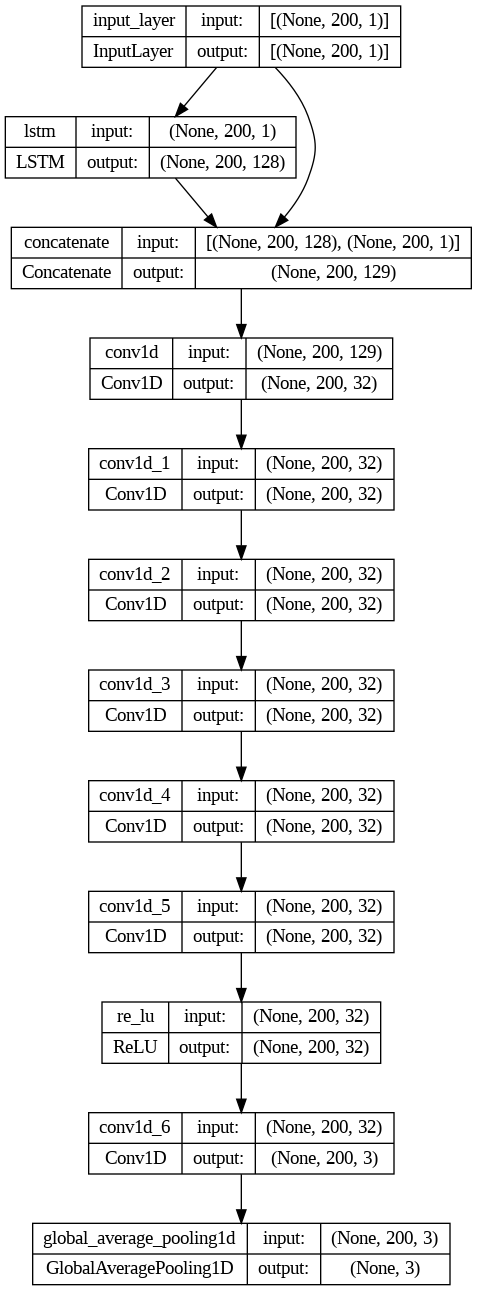

In [ ]:
input_shape = np.expand_dims(X_train[0], axis=1).shape
output_shape = y_train[0].shape

print(input_shape, output_shape)

model = build_model(input_shape, output_shape)
model.summary()
tfk.utils.plot_model(model, expand_nested=True, show_shapes=True)

# Train model

In [ ]:
# Train the model
batch_size = 64
epochs = 70

history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data=(X_val, y_val),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', min_delta=0.0005, patience=18, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', min_delta=0.0005, patience=10, factor=0.1, min_lr=1e-6)
    ]
).history

Epoch 1/70
1819/1819 [==============================] - 39s 16ms/step - loss: 0.0147 - val_loss: 0.0120 - lr: 0.0010
Epoch 2/70
1819/1819 [==============================] - 24s 13ms/step - loss: 0.0075 - val_loss: 0.0060 - lr: 0.0010
Epoch 3/70
1819/1819 [==============================] - 25s 14ms/step - loss: 0.0064 - val_loss: 0.0062 - lr: 0.0010
Epoch 4/70
1819/1819 [==============================] - 26s 14ms/step - loss: 0.0061 - val_loss: 0.0061 - lr: 0.0010
Epoch 5/70
1819/1819 [==============================] - 27s 15ms/step - loss: 0.0058 - val_loss: 0.0061 - lr: 0.0010
Epoch 6/70
1819/1819 [==============================] - 26s 14ms/step - loss: 0.0056 - val_loss: 0.0079 - lr: 0.0010
Epoch 7/70
1819/1819 [==============================] - 25s 14ms/step - loss: 0.0055 - val_loss: 0.0054 - lr: 0.0010
Epoch 8/70
1819/1819 [==============================] - 26s 14ms/step - loss: 0.0054 - val_loss: 0.0064 - lr: 0.0010
Epoch 9/70
1819/1819 [==============================] - 28s 15ms

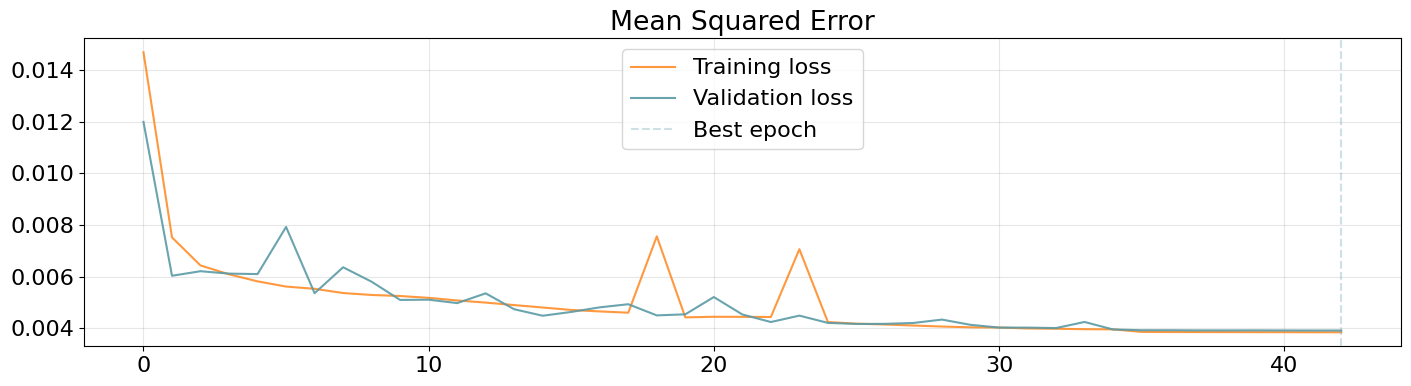

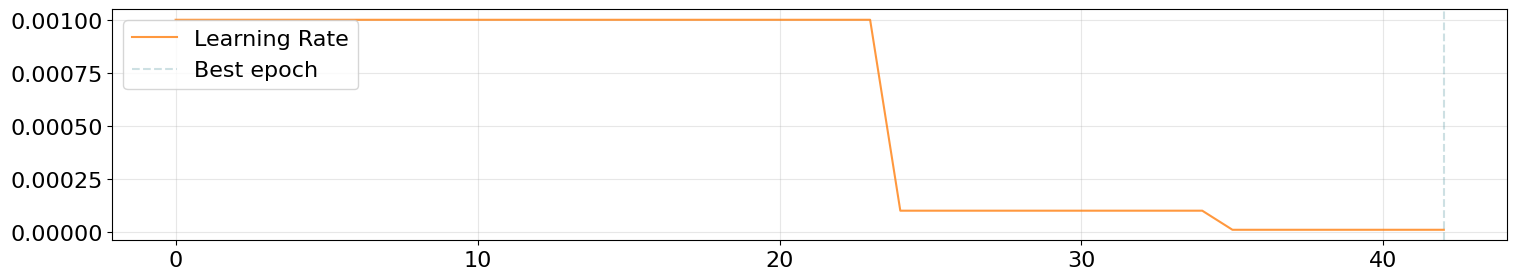

In [ ]:
best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Squared Error')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [ ]:
model.save('autoregressive_model_telescope_3')

# Evaluate performance

In [ ]:
model = tfk.models.load_model('autoregressive_model_telescope_3')

## Simple Baseline performance

In [ ]:
class Persistence:

    def __init__(self, telescope):
        super()
        self.telescope = telescope

    def predict(self, X):
        return X[:,-self.telescope:]

In [ ]:
persistence_model = Persistence(telescope)
# Predict the test set using the model
predictions = persistence_model.predict(X_test)

# Print the shape of the predictions
print(f"Predictions shape: {predictions.shape}")

# Calculate and print Mean Squared Error (MSE)
mean_squared_error = tfk.metrics.mean_squared_error(y_test.flatten(), predictions.flatten()).numpy()
print(f"Mean Squared Error: {mean_squared_error}")

# Calculate and print Mean Absolute Error (MAE)
mean_absolute_error = tfk.metrics.mean_absolute_error(y_test.flatten(), predictions.flatten()).numpy()
print(f"Mean Absolute Error: {mean_absolute_error}")

Predictions shape: (13113, 18)
Mean Squared Error: 0.025472508743405342
Mean Absolute Error: 0.11098697036504745


In [ ]:
class Constant:
    def __init__(self, telescope):
        super()
        self.telescope = telescope

    def predict(self, X):
        return np.ones((X.shape[0], telescope)) * X[:,-1].reshape(X.shape[0],1)

In [ ]:
constant_model = Constant(telescope)
# Predict the test set using the model
predictions = constant_model.predict(X_test)

# Print the shape of the predictions
print(f"Predictions shape: {predictions.shape}")

# Calculate and print Mean Squared Error (MSE)
mean_squared_error = tfk.metrics.mean_squared_error(y_test.flatten(), predictions.flatten()).numpy()
print(f"Mean Squared Error: {mean_squared_error}")

# Calculate and print Mean Absolute Error (MAE)
mean_absolute_error = tfk.metrics.mean_absolute_error(y_test.flatten(), predictions.flatten()).numpy()
print(f"Mean Absolute Error: {mean_absolute_error}")

Predictions shape: (13113, 18)
Mean Squared Error: 0.016565513478277845
Mean Absolute Error: 0.08282220830986152


## Model Performance

In [ ]:
# Autoregressive Forecasting
reg_predictions = np.array([])
X_temp = X_test

# Go from 0 to telescope  with a step of direct_telescope of the autoregressive_telescope
for reg in range(0,telescope,direct_telescope):

    pred_temp = model.predict(X_temp,verbose=1)

    if(len(reg_predictions)==0):
        reg_predictions = pred_temp
    else:
        reg_predictions = np.concatenate((reg_predictions,pred_temp),axis=1)

    X_temp = np.concatenate((X_temp[:,direct_telescope:],pred_temp), axis=1)

410/410 [==============================] - 2s 6ms/step


In [ ]:
# Print the shape of the predictions
print(f"Predictions shape: {reg_predictions.shape}")

# Calculate and print Mean Squared Error (MSE)
mean_squared_error = tfk.metrics.mean_squared_error(y_test.flatten(), reg_predictions.flatten()).numpy()
print(f"Mean Squared Error: {mean_squared_error}")

# Calculate and print Mean Absolute Error (MAE)
mean_absolute_error = tfk.metrics.mean_absolute_error(y_test.flatten(), reg_predictions.flatten()).numpy()
print(f"Mean Absolute Error: {mean_absolute_error}")

Predictions shape: (13113, 18)
Mean Squared Error: 0.01211557537317276
Mean Absolute Error: 0.07300002872943878
